In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from Games import *
import Utility
from os import listdir
from os.path import join
from json import load
from glob import glob

In [3]:
PALETTE = {
    "policy": "red", 
    "q": "blue", 
    "random": "green", 
    "GreedyRelative": "purple"
}

In [4]:
def get_agent_playthroughs(config, allow_empty_link):
    playthroughs = []
    for filename in listdir(config.BASE_DIR):
        if filename.startswith('fitagent_playthrough_') and str(allow_empty_link) in filename:
            with open(join(config.BASE_DIR, filename), 'r') as f:
                data = load(f)
                playthroughs.append((filename, data))
            
    return playthroughs

In [5]:
def get_player_playthroughs(config, player_name):
    playthroughs = []
    starts_with_str = f'player_{player_name}_fit_playthrough_{config.NAME}'
    
    for filename in listdir(config.BASE_DIR):
        if filename.startswith(starts_with_str):
            with open(join(config.BASE_DIR, filename), 'r') as f:
                data = load(f)
                playthroughs.append((filename, data))
            
    return playthroughs

In [6]:
def heatmap(playthrough_data, graph, filename, bounds):
    max_x, max_y = bounds
    data = np.zeros((max_x + 1, max_y + 1))
    mask = np.ones((max_x + 1, max_y + 1))
    for n in graph.nodes:
        if '__' in n:
            continue
            
        a,b,_ = n.split(',')
        mask[int(a)][int(b)] = 0.0
    
    for run in playthrough_data:
        for segment, _, _, _ in run:
            if '__' in segment:
                continue
                
            a, b, _ = segment.split(',')
            data[int(a)][int(b)] += 1.0
    
    sns.set(rc = {'figure.figsize':(8,4)})
    ax = sns.heatmap(
        data, 
        mask=mask,
        square=True,
        cmap='Blues'
    )
#     ax = sns.heatmap(data, square=True)
    ax.invert_yaxis()
    ax.set_title(filename)
    ax.set_facecolor("gray")
    
    # reduce frequency for xticks
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 5 == 0:  
            label.set_visible(True)
        else:
            label.set_visible(False)
    
    # reduce frequency for y ticks
    for ind, label in enumerate(ax.get_yticklabels()):
        if ind % 5 == 0:  
            label.set_visible(True)
        else:
            label.set_visible(False)

    plt.show()

In [7]:
def plot_reward_over_time(playthroughs):
    plot_data = {}
    for filename, data in playthroughs:
        legend_name = filename.split('.')[0].split('_')[-2]
        plot_data[legend_name] = []
        total_reward = 0
        
        for level in data:
            for _, _, _, r in level:
                total_reward += r
            
            plot_data[legend_name].append(total_reward)
    
    sns.set(rc = {'figure.figsize':(15,8)})
    ax = sns.lineplot(data=plot_data, palette=PALETTE)
    ax.set_title('Reward over Time')
        
    plt.show()

## Agent :: DungeonGrams

In [8]:
config = DungeonGrams
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config, False)

Loading links from: ./GramElitesData/DungeonData/gram_elites/links_True.json


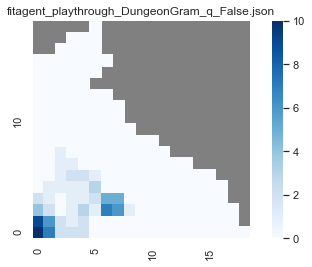

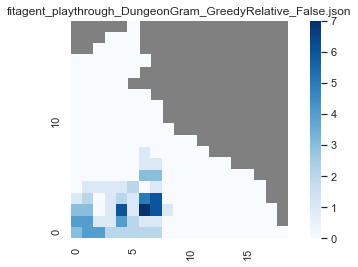

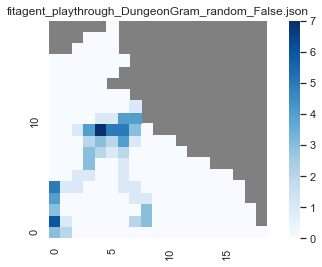

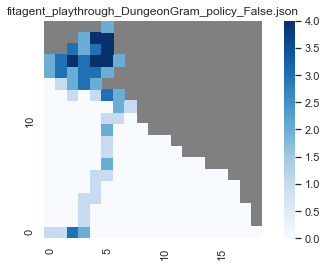

In [9]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

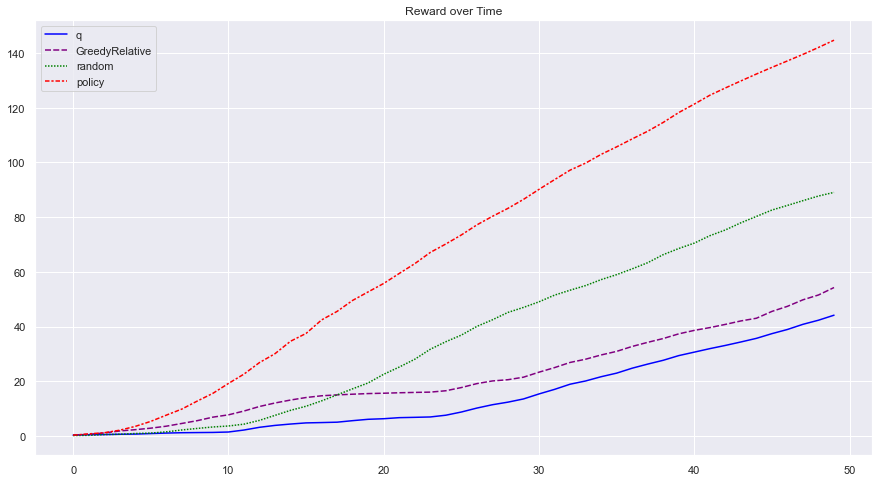

In [10]:
plot_reward_over_time(playthroughs)

## Agent :: DungeonGrams + Food

In [11]:
config = DungeonGrams
graph = Utility.get_graph(config, False)
playthroughs = get_agent_playthroughs(config, False)

Loading links from: ./GramElitesData/DungeonData/gram_elites/links_False.json


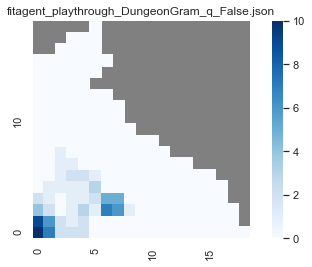

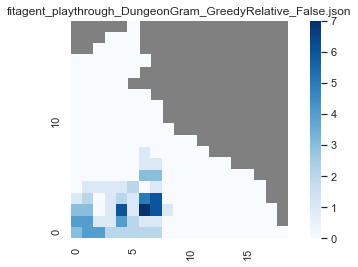

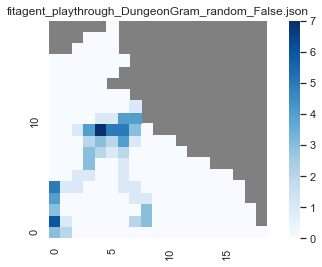

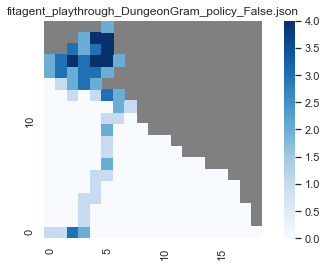

In [12]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

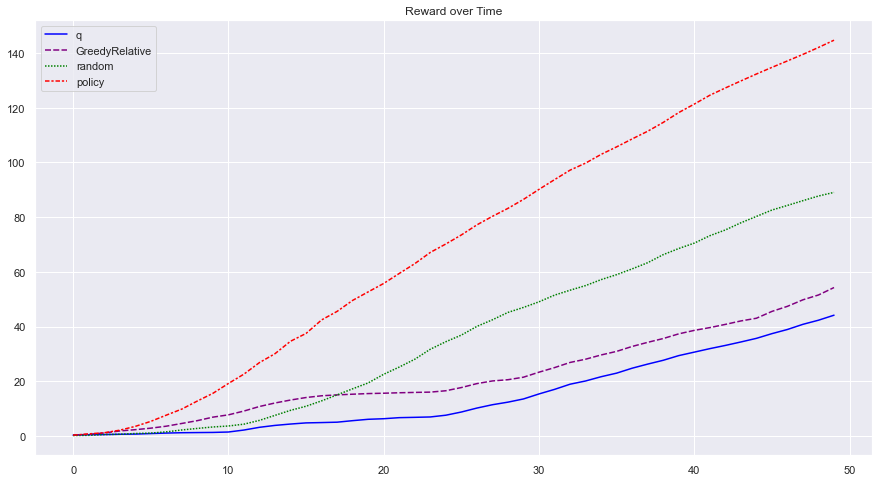

In [13]:
plot_reward_over_time(playthroughs)

## Agent :: Mario

In [14]:
config = Mario
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config, True)

Loading links from: ./GramElitesData/MarioData/gram_elites/links_True.json


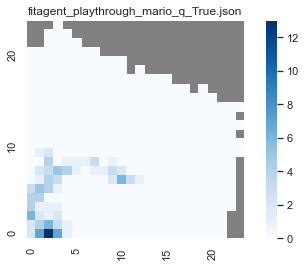

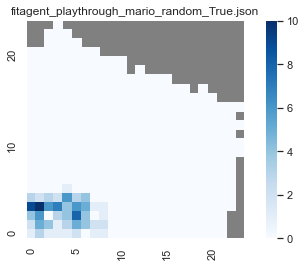

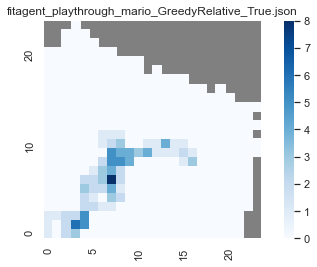

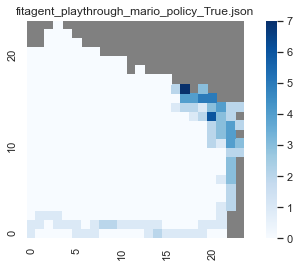

In [15]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

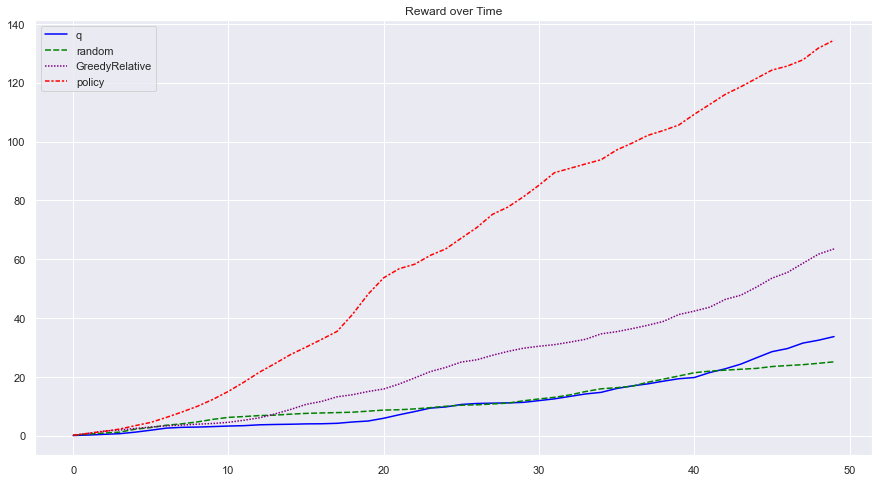

In [16]:
plot_reward_over_time(playthroughs)

## Agent ::  Icarus

In [17]:
config = Icarus
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config, True)

Loading links from: ./GramElitesData/IcarusData/gram_elites/links_True.json


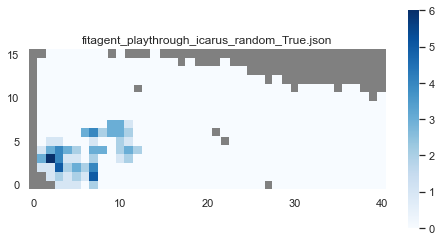

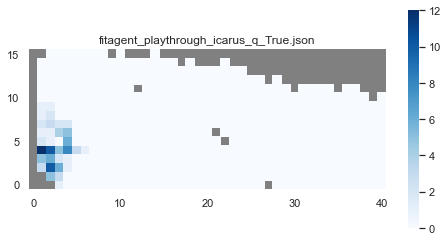

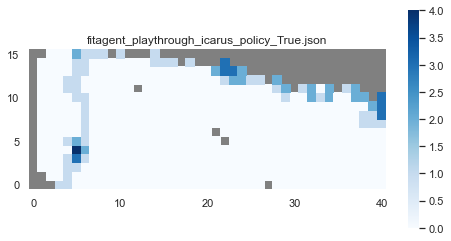

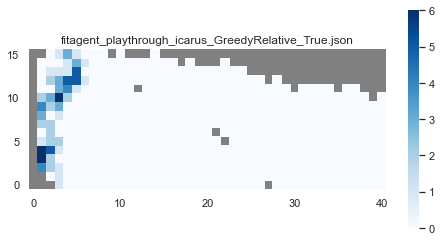

In [18]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

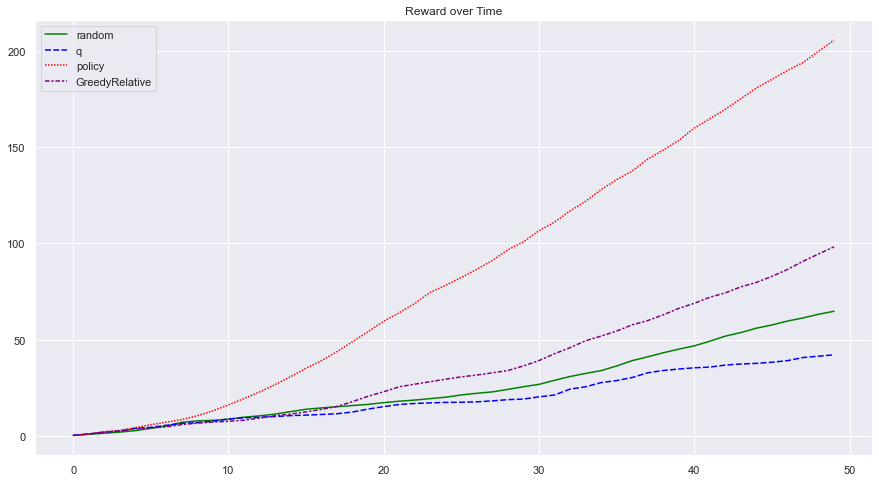

In [19]:
plot_reward_over_time(playthroughs)

# Player Personas

In [20]:
def get_all_player_playthroughs(config, allow_empty_link, reward_str):
    playthroughs = []
    for path in glob(join(config.BASE_DIR, f'player_*_{allow_empty_link}_reward_{reward_str}.json')):
        path_split = path.split('/')[-1].split('_')
        player = path_split[1]
        director = path_split[-5]
        
        with open(path, 'r') as f:
            playthroughs.append((player, director, load(f)))

    return playthroughs

In [21]:
def get_df(playthroughs, order_column):
    data = []
    labels = ['Director', 'Player', 'Percent Complete', 'Player Reward', 'Design Reward','Total Reward']
    players = set()
    RUNS_SIZE = len(player_playthroughs[2][2][0])
    
    for player, director, run_data in playthroughs:
        players.add(player)
        for run in run_data:
            run_percent_complete = 0
            run_player_reward = 0
            run_design_reward = 0
            run_total_reward = 0

            for lvl in run:
                run_percent_complete += lvl['percent_complete']
                run_player_reward += lvl['percent_player_reward']
                run_design_reward += lvl['percent_design_reward']
                run_total_reward += lvl['percent_total_reward']
                    
            data.append((
                director, 
                player, 
                run_percent_complete / RUNS_SIZE, 
                run_player_reward / RUNS_SIZE, 
                run_design_reward / RUNS_SIZE, 
                run_total_reward / RUNS_SIZE))
            
    df = pd.DataFrame(data, columns=labels) \
         .groupby(['Player', 'Director']) \
         .agg(['mean', 'std']) \
         .sort_values(by=['Player', (order_column, 'mean')], ascending=False)
    df = df.applymap("{0:.3f}".format)
    return df

In [22]:
def plot_player_personas_over_time(playthroughs, column, reward_name):
    player_data = {}
    for player, alg, data in player_playthroughs:
        if player not in player_data:
            player_data[player] = []
            
        for session in data:
            total_reward = 0
            for i, lvl in enumerate(session):
                total_reward += lvl[column]
                player_data[player].append((alg, i, total_reward))
                
    # sort keys so the output is always in the same order
    player_names = list(player_data.keys())
    player_names.sort()
    
    # build plots and set title
    fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(16,8))
    fig.suptitle(f'Reward Over Time for {reward_name}')
    
    # fill in each plot
    for i, player in enumerate(player_names):
        plot_df = pd.DataFrame(player_data[player], columns=['alg', 'level', 'reward'])
        
        if i >= 4:
            x,y = i-4, 1
        else:
            x,y = i, 0
            
        ax = sns.lineplot(ax=axes[y, x], data=plot_df, x='level', y='reward', hue='alg', palette=PALETTE)
        ax.get_legend().remove()
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(player)
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=2, bbox_to_anchor=(.9, 0.99))
    fig.text(0.5, 0.04, 'Level', ha='center', size=14)
    fig.text(0.08, 0.5, 'Reward', va='center', rotation='vertical', size=14)
    plt.show()

# Player Personas :: Mario :: Reward=Designer

In [23]:
config = Mario
REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.DESIGNER)
graph = Utility.get_graph(config, True)
player_playthroughs = get_all_player_playthroughs(config, True, REWARD_STR)
df = get_df(player_playthroughs, 'Design Reward')
mario_player_persona_designer_table = df.to_latex() # store in case we want it
df

Loading links from: ./GramElitesData/MarioData/gram_elites/links_True.json


Percent Complete         \
                                                             mean    std   
Player                            Director                                 
Mediocre Player Likes High B      policy                    0.857  0.130   
                                  GreedyRelative            1.000  0.000   
                                  random                    1.000  0.000   
                                  q                         1.000  0.000   
Mediocre Player Likes High A      policy                    0.758  0.131   
                                  GreedyRelative            1.000  0.000   
                                  q                         1.000  0.000   
                                  random                    1.000  0.000   
Mediocre Player Likes Hard Levels policy                    0.966  0.061   
                                  GreedyRelative            1.000  0.000   
                                  random                    1.000  0.000   
                                  q                         1.000  0.000   
Mediocre Player Likes Easy Levels policy                    0.826  0.170   
                                  GreedyRelative            1.000  0.000   
                                  random                    0.993  0.021   
                                  q                         1.000  0.000   
Good Player Likes Hard Levels     policy                    1.000  0.000   
                                  q                         1.000  0.000   
                                  GreedyRelative            1.000  0.000   
                                  random                    1.000  0.000   
Good Player Likes Easy Levels     policy                    1.000  0.001   
                                  GreedyRelative            1.000  0.000   
                                  q                         1.000  0.000   
                                  random                    1.000  0.000   
Bad Player Likes Hard Levels      policy                    0.373  0.049   
                                  GreedyRelative            0.871  0.203   
                                  random                    0.852  0.167   
                                  q                         0.933  0.128   
Bad Player Likes Easy Levels      policy                    0.304  0.048   
                                  GreedyRelative            0.885  0.162   
                                  q                         0.868  0.146   
                                  random                    0.834  0.187   

                                                 Player Reward         \
                                                          mean    std   
Player                            Director                              
Mediocre Player Likes High B      policy                 0.463  0.127   
                                  GreedyRelative         0.157  0.074   
                                  random                 0.095  0.065   
                                  q                      0.106  0.060   
Mediocre Player Likes High A      policy                 0.310  0.191   
                                  GreedyRelative         0.168  0.079   
                                  q                      0.125  0.076   
                                  random                 0.113  0.098   
Mediocre Player Likes Hard Levels policy                 0.313  0.023   
                                  GreedyRelative         0.138  0.027   
                                  random                 0.104  0.059   
                                  q                      0.095  0.042   
Mediocre Player Likes Easy Levels policy                 0.707  0.036   
                                  GreedyRelative         0.864  0.020   
                                  random                 0.896  0.059   
                                  q                      0.910  0.040   
G

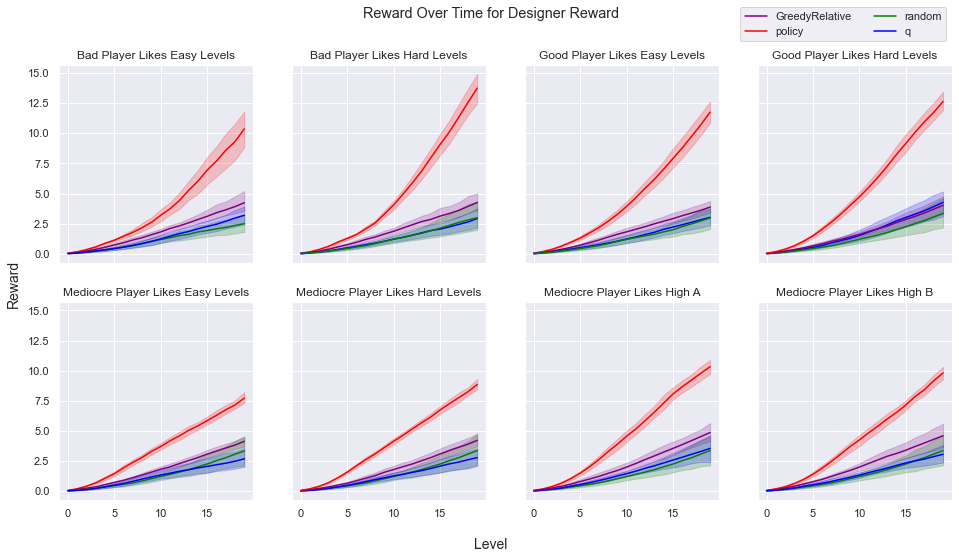

In [24]:
plot_player_personas_over_time(player_playthroughs, 'percent_design_reward', 'Designer Reward')

# Player Personas :: Mario :: Reward=Player

In [25]:
REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.PLAYER)
player_playthroughs = get_all_player_playthroughs(config, True, REWARD_STR)
df = get_df(player_playthroughs, 'Player Reward')
mario_player_persona_player_table = df.to_latex() # store in case we want it
df

Percent Complete         \
                                                             mean    std   
Player                            Director                                 
Mediocre Player Likes High B      policy                    0.684  0.127   
                                  GreedyRelative            1.000  0.000   
                                  q                         1.000  0.000   
                                  random                    1.000  0.000   
Mediocre Player Likes High A      policy                    0.737  0.122   
                                  GreedyRelative            1.000  0.000   
                                  random                    1.000  0.000   
                                  q                         1.000  0.000   
Mediocre Player Likes Hard Levels policy                    0.704  0.128   
                                  GreedyRelative            1.000  0.000   
                                  q                         1.000  0.000   
                                  random                    1.000  0.000   
Mediocre Player Likes Easy Levels policy                    1.000  0.000   
                                  GreedyRelative            1.000  0.000   
                                  q                         1.000  0.000   
                                  random                    0.993  0.021   
Good Player Likes Hard Levels     policy                    0.997  0.009   
                                  GreedyRelative            1.000  0.000   
                                  q                         1.000  0.000   
                                  random                    1.000  0.000   
Good Player Likes Easy Levels     policy                    1.000  0.000   
                                  GreedyRelative            1.000  0.000   
                                  q                         1.000  0.000   
                                  random                    1.000  0.000   
Bad Player Likes Hard Levels      GreedyRelative            0.762  0.204   
                                  policy                    0.755  0.225   
                                  q                         0.910  0.147   
                                  random                    0.852  0.167   
Bad Player Likes Easy Levels      policy                    1.000  0.000   
                                  GreedyRelative            1.000  0.000   
                                  q                         0.971  0.062   
                                  random                    0.834  0.187   

                                                 Player Reward         \
                                                          mean    std   
Player                            Director                              
Mediocre Player Likes High B      policy                 0.467  0.132   
                                  GreedyRelative         0.142  0.045   
                                  q                      0.111  0.073   
                                  random                 0.095  0.065   
Mediocre Player Likes High A      policy                 0.518  0.134   
                                  GreedyRelative         0.179  0.069   
                                  random                 0.113  0.098   
                                  q                      0.083  0.062   
Mediocre Player Likes Hard Levels policy                 0.368  0.049   
                                  GreedyRelative         0.129  0.038   
                                  q                      0.108  0.043   
                                  random                 0.104  0.059   
Mediocre Player Likes Easy Levels policy                 0.994  0.002   
                                  GreedyRelative         0.935  0.015   
                                  q                      0.907  0.038   
                                  random                 0.896  0.059   
G

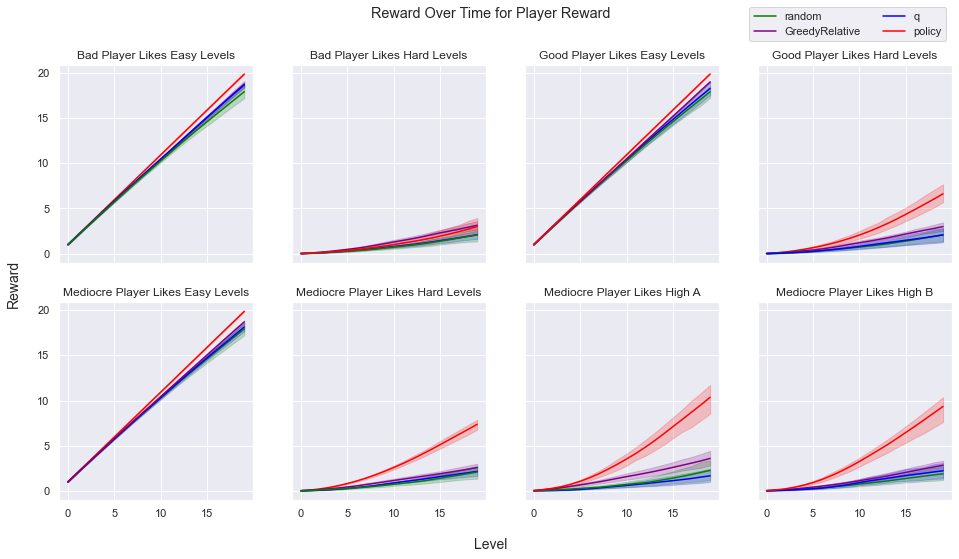

In [26]:
plot_player_personas_over_time(player_playthroughs, 'percent_player_reward', 'Player Reward')

# Player Personas :: Mario :: Reward=Both

In [27]:
REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.BOTH)
player_playthroughs = get_all_player_playthroughs(config, True, REWARD_STR)
df = get_df(player_playthroughs, 'Total Reward')
mario_player_persona_player_table = df.to_latex() # store in case we want it
df

Percent Complete         \
                                                             mean    std   
Player                            Director                                 
Mediocre Player Likes High B      policy                    0.919  0.095   
                                  GreedyRelative            1.000  0.000   
                                  random                    1.000  0.000   
                                  q                         1.000  0.000   
Mediocre Player Likes High A      policy                    0.939  0.092   
                                  GreedyRelative            1.000  0.000   
                                  random                    1.000  0.000   
                                  q                         1.000  0.000   
Mediocre Player Likes Hard Levels policy                    0.952  0.070   
                                  q                         1.000  0.000   
                                  GreedyRelative            1.000  0.000   
                                  random                    1.000  0.000   
Mediocre Player Likes Easy Levels random                    0.993  0.021   
                                  q                         1.000  0.000   
                                  GreedyRelative            1.000  0.000   
                                  policy                    1.000  0.000   
Good Player Likes Hard Levels     policy                    1.000  0.000   
                                  GreedyRelative            1.000  0.000   
                                  random                    1.000  0.000   
                                  q                         1.000  0.000   
Good Player Likes Easy Levels     random                    1.000  0.000   
                                  q                         1.000  0.000   
                                  GreedyRelative            1.000  0.000   
                                  policy                    1.000  0.000   
Bad Player Likes Hard Levels      policy                    0.599  0.191   
                                  GreedyRelative            0.810  0.214   
                                  random                    0.852  0.167   
                                  q                         0.928  0.128   
Bad Player Likes Easy Levels      q                         0.886  0.204   
                                  GreedyRelative            0.965  0.112   
                                  random                    0.834  0.187   
                                  policy                    0.986  0.031   

                                                 Player Reward         \
                                                          mean    std   
Player                            Director                              
Mediocre Player Likes High B      policy                 0.281  0.057   
                                  GreedyRelative         0.124  0.057   
                                  random                 0.095  0.065   
                                  q                      0.111  0.069   
Mediocre Player Likes High A      policy                 0.356  0.106   
                                  GreedyRelative         0.143  0.078   
                                  random                 0.113  0.098   
                                  q                      0.094  0.048   
Mediocre Player Likes Hard Levels policy                 0.294  0.039   
                                  q                      0.126  0.055   
                                  GreedyRelative         0.125  0.032   
                                  random                 0.104  0.059   
Mediocre Player Likes Easy Levels random                 0.896  0.059   
                                  q                      0.902  0.036   
                                  GreedyRelative         0.922  0.026   
                                  policy                 0.941  0.026   
G

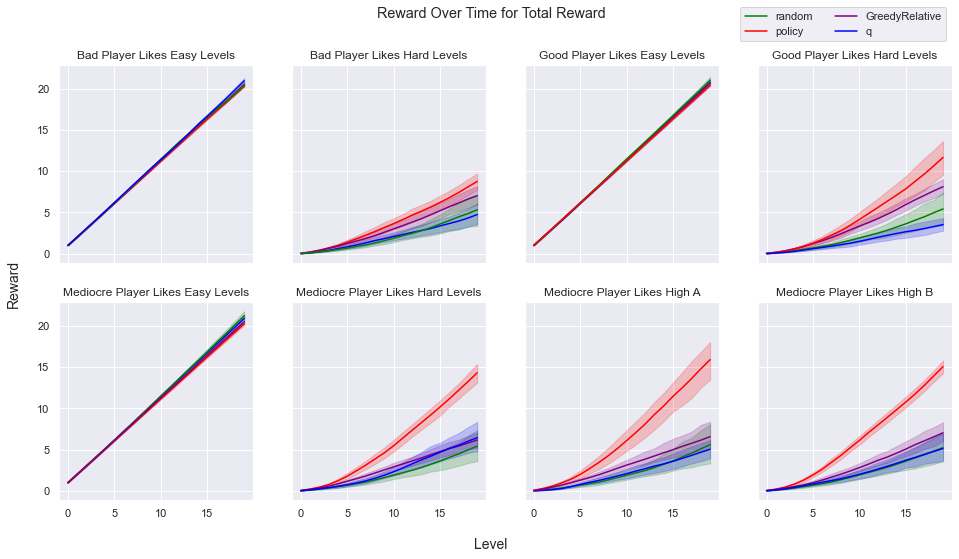

In [28]:
plot_player_personas_over_time(player_playthroughs, 'percent_total_reward', 'Total Reward')

# Player Personas :: Icarus

In [29]:
config = Icarus
graph = Utility.get_graph(config, True)
playthroughs = get_all_player_playthroughs(config, True)
df = get_df(playthroughs)
icarus_player_persona_table = df.to_latex() # store in case we want it
df

Loading links from: ./GramElitesData/IcarusData/gram_elites/links_True.json


TypeError: get_all_player_playthroughs() missing 1 required positional argument: 'reward_str'

In [ ]:
plot_player_personas_over_time(player_playthroughs, 'Bad Player Likes Easy Levels')

In [ ]:
plot_player_personas_over_time(player_playthroughs, 'Bad Player Likes Hard Levels')

In [ ]:
plot_player_personas_over_time(player_playthroughs, 'Good Player Likes Hard Levels')

# Player Personas :: DungeonGrams

In [ ]:
config = DungeonGrams
graph = Utility.get_graph(config, True)
playthroughs = get_all_player_playthroughs(config, True)
df = get_df(playthroughs)
dg_player_persona_table = df.to_latex() # store in case we want it
df

In [ ]:
plot_player_personas_over_time(player_playthroughs, 'Mediocre Player Likes Easy Levels')

In [ ]:
plot_player_personas_over_time(player_playthroughs, 'Mediocre Player Likes Hard Levels')

In [ ]:
plot_player_personas_over_time(player_playthroughs, 'Mediocre Player Likes High A')